In [45]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import itertools
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import classification_report, f1_score , confusion_matrix



# Tensorflow Libraries
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout , BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers,models,Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')



# Loading Dataset

In [46]:

path = "/kaggle/input/animal-image-dataset-90-different-animals/animals/animals"
path2= "/kaggle/input/vehicle-images-dataset"
path3= "/kaggle/input/dollar-street-dataset/Dollar street trial"

data = {"imgpath": [] , "labels": [] }

category = os.listdir(path)
for folder in category:
    folderpath = os.path.join(path , folder)
    if folder.startswith("cow") or folder.startswith("rat") or folder.startswith("cat") or folder.startswith("dog") or folder.startswith("cockroach"):
        filelist = os.listdir(folderpath)
        for file in filelist:
            fpath = os.path.join(folderpath, file)
            data["imgpath"].append(fpath)
            data["labels"].append(folder)
        
category2 = os.listdir(path2)
for folder in category2:
    folderpath = os.path.join(path2 , folder)
    filelist = os.listdir(folderpath)
    for file in filelist:
        fpath = os.path.join(folderpath, file)
        data["imgpath"].append(fpath)
        data["labels"].append(folder)
        

for folder in os.listdir(path3):
    subfolder_path = os.path.join(path3, folder)
    
    # Check if the subfolder is an 'Objects' category and not an 'Abstract' category
    if (folder.startswith("Objects__refrigerators") or folder.startswith("Objects__tvs") or folder.startswith("Objects__wall-clocks") or folder.startswith("Objects__sofas") )  and not folder.startswith("Abstract__"):
        label = folder.replace("Objects__", "")
        
        # Iterate through 'ann' and 'img' subfolders
        for subsubfolder in ['ann', 'img']:
            img_subfolder_path = os.path.join(subfolder_path, subsubfolder)
            
            # Iterate through the image files in the 'img' subfolder
            for image_file in os.listdir(img_subfolder_path):
                if image_file.endswith(".jpg"):  # Adjust the file extension if necessary
                    img_path = os.path.join(img_subfolder_path, image_file)
                    data["imgpath"].append(img_path)
                    data["labels"].append(label)
            
      

df = pd.DataFrame(data) 

#Convert labels to numbers
lb = LabelEncoder()
df['encoded_labels'] = lb.fit_transform(df['labels'])

In [47]:
unique_labels = df['labels'].unique()
print("Unique Labels:", unique_labels)


Unique Labels: ['dog' 'rat' 'caterpillar' 'cow' 'cockroach' 'cat' 'Van' 'Truck'
 'Big Truck' 'Multi Purpose Vehicle' 'Sedan' 'Sport Utility Vehicle'
 'City Car' 'tvs' 'refrigerators' 'sofas' 'wall-clocks']


# Split the Dataset into Train and Test

In [48]:
train_df, Temp_df = train_test_split(df,  train_size= 0.70 , shuffle=True, random_state=124)
valid_df , test_df = train_test_split(Temp_df ,  train_size= 0.70 , shuffle=True, random_state=124)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("----------Train-------------")
print(train_df[["imgpath", "labels"]].head(5))
print(train_df.shape)
print("--------Validation----------")
print(valid_df[["imgpath", "labels"]].head(5))
print(valid_df.shape)
print("----------Test--------------")
print(test_df[["imgpath", "labels"]].head(5))
print(test_df.shape)

----------Train-------------
                                             imgpath    labels
0  /kaggle/input/vehicle-images-dataset/Van/Image...       Van
1  /kaggle/input/vehicle-images-dataset/City Car/...  City Car
2  /kaggle/input/vehicle-images-dataset/City Car/...  City Car
3  /kaggle/input/vehicle-images-dataset/Truck/Ima...     Truck
4  /kaggle/input/vehicle-images-dataset/Van/Image...       Van
(11807, 3)
--------Validation----------
                                             imgpath                 labels
0  /kaggle/input/dollar-street-dataset/Dollar str...            wall-clocks
1  /kaggle/input/vehicle-images-dataset/Van/Image...                    Van
2  /kaggle/input/vehicle-images-dataset/Sport Uti...  Sport Utility Vehicle
3  /kaggle/input/vehicle-images-dataset/City Car/...               City Car
4  /kaggle/input/vehicle-images-dataset/City Car/...               City Car
(3542, 3)
----------Test--------------
                                             imgpath      

# Sample Data View

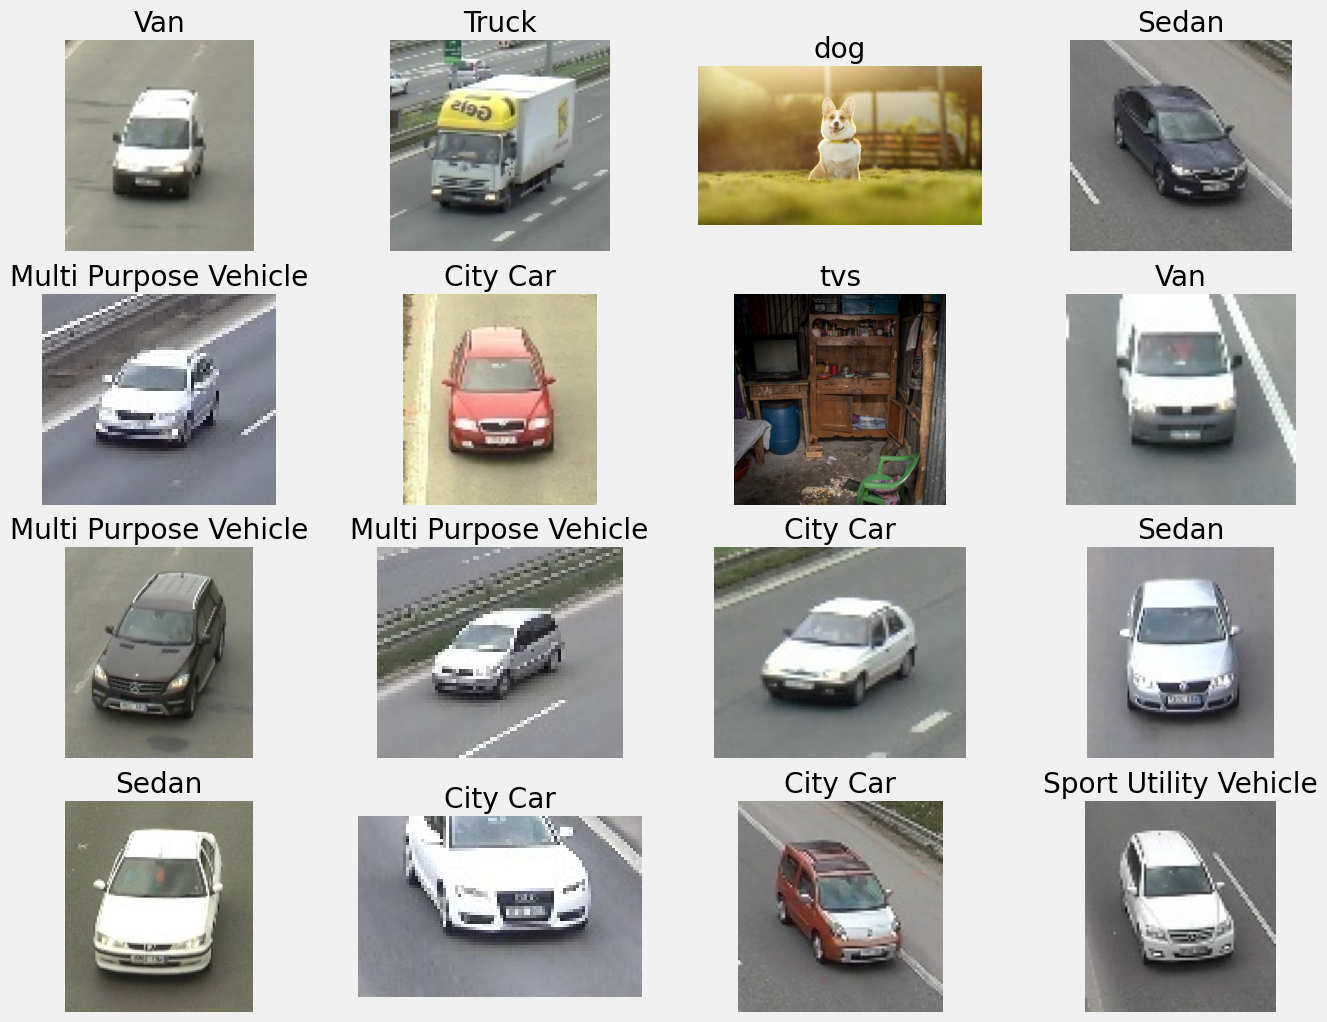

In [49]:
plt.figure(figsize=(15,12))
for i, row in test_df.sample(n=16).reset_index().iterrows():
    plt.subplot(4,4,i+1)
    image_path = row['imgpath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()

In [50]:
df['labels'].unique()

array(['dog', 'rat', 'caterpillar', 'cow', 'cockroach', 'cat', 'Van',
       'Truck', 'Big Truck', 'Multi Purpose Vehicle', 'Sedan',
       'Sport Utility Vehicle', 'City Car', 'tvs', 'refrigerators',
       'sofas', 'wall-clocks'], dtype=object)

# Creating Data Loaders

In [51]:
%%time

BATCH_SIZE = 15
IMAGE_SIZE = (224, 224)


generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
    # there could be image augmentation here
)

# Split the data into three categories.
train_images = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

val_images = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_images = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 11807 validated image filenames belonging to 17 classes.
Found 3542 validated image filenames belonging to 17 classes.
Found 1519 validated image filenames belonging to 17 classes.
CPU times: user 421 ms, sys: 436 ms, total: 857 ms
Wall time: 23.6 s


In [52]:
df['labels'].unique()

array(['dog', 'rat', 'caterpillar', 'cow', 'cockroach', 'cat', 'Van',
       'Truck', 'Big Truck', 'Multi Purpose Vehicle', 'Sedan',
       'Sport Utility Vehicle', 'City Car', 'tvs', 'refrigerators',
       'sofas', 'wall-clocks'], dtype=object)

# Model Structure

In [53]:
import tensorflow as tf

# Check your TensorFlow version
print("TensorFlow version:", tf.__version__)

# Load the pretrained model
pretrained_model = tf.keras.applications.EfficientNetB2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

# Create a new input tensor with the desired data type (float32)
input_tensor = tf.keras.layers.Input(shape=(224, 224, 3))
x = input_tensor

# Preprocess your input data here (e.g., normalization, resizing, etc.)

# Apply the EfficientNetB3 model
x = pretrained_model(x)

# Freezing the layers of a pretrained neural network
for layer in pretrained_model.layers:
    layer.trainable = False

# Continue building your model as needed
# ...


TensorFlow version: 2.8.0


In [54]:
num_classes = len(set(train_images.classes))


# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.15),
  layers.experimental.preprocessing.RandomZoom(0.15),
  layers.experimental.preprocessing.RandomContrast(0.15),
], name='AugmentationLayer')



inputs = layers.Input(shape = (224,224,3), name='inputLayer')
x = augment(inputs)
pretrain_out = pretrained_model(x, training = False)
x = layers.Dense(256)(pretrain_out)
x = layers.Activation(activation="relu")(x) 
x = BatchNormalization()(x)
x = layers.Dropout(0.45)(x)
x = layers.Dense(num_classes)(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x) # mixed_precision need separated Dense and Activation layers
model = Model(inputs=inputs, outputs=outputs)



model.compile(
    optimizer=Adam(0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# model.load_weights('./checkpoints/my_checkpoint')
print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 AugmentationLayer (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb2 (Functional)  (None, 1408)             7768569   
                                                                 
 dense_4 (Dense)             (None, 256)               360704    
                                                                 
 activation_2 (Activation)   (None, 256)               0         
                                                                 
 batch_normalization_2 (Batc  (None, 256)              1024      
 hNormalization)                                           

# Training : Transfer Learning

In [55]:
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=10,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 3,
                               restore_best_weights = True), # if val loss decreases for 10 epochs in a row, stop training,
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min') 
    ]
)
model.save_weights('./checkpoints/my_checkpoint')

Epoch 1/10
788/788 [==============================] - 87s 98ms/step - loss: 1.6463 - accuracy: 0.4568 - val_loss: 1.0446 - val_accuracy: 0.5819 - lr: 5.0000e-04
Epoch 2/10
788/788 [==============================] - 44s 56ms/step - loss: 1.1046 - accuracy: 0.5692 - val_loss: 0.9417 - val_accuracy: 0.6285 - lr: 5.0000e-04
Epoch 3/10
788/788 [==============================] - 43s 54ms/step - loss: 1.0053 - accuracy: 0.6052 - val_loss: 0.9078 - val_accuracy: 0.6138 - lr: 5.0000e-04
Epoch 4/10
788/788 [==============================] - 44s 55ms/step - loss: 0.9750 - accuracy: 0.6131 - val_loss: 0.8082 - val_accuracy: 0.6621 - lr: 5.0000e-04
Epoch 5/10
788/788 [==============================] - 43s 55ms/step - loss: 0.9234 - accuracy: 0.6347 - val_loss: 0.8081 - val_accuracy: 0.6714 - lr: 5.0000e-04
Epoch 7/10
788/788 [==============================] - 44s 56ms/step - loss: 0.9099 - accuracy: 0.6395 - val_loss: 0.7786 - val_accuracy: 0.6894 - lr: 5.0000e-04
Epoch 8/10
788/788 [==============

# Display model performance

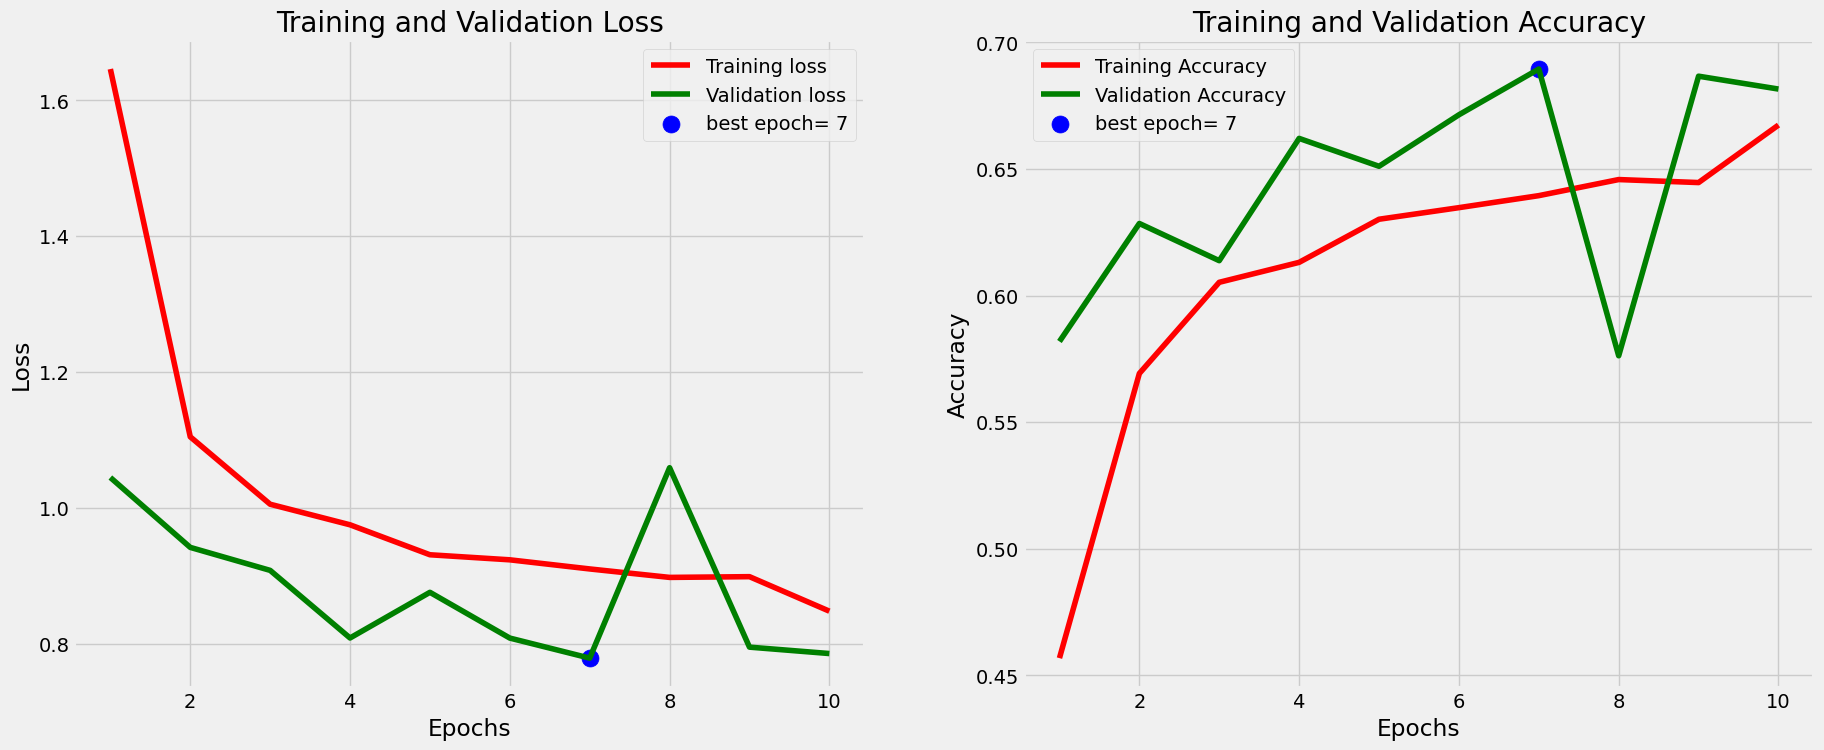

In [56]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show()

# Training : Fine Tuning

In [57]:
pretrained_model.trainable = True
for layer in pretrained_model.layers:
    if isinstance(layer, layers.BatchNormalization): # set BatchNorm layers as not trainable
        layer.trainable = False
        
# let`s see first 10 layers
for l in pretrained_model.layers[:10]:
    print(l.name, l.trainable)

model.compile(
    optimizer=Adam(0.00001), # fine tuning requires very little learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# model.load_weights('./checkpoints/my_checkpoint')
print(model.summary())
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=15,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 3,
                               restore_best_weights = True), # if val loss decreases for 5 epochs in a row, stop training,
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min') 
    ]
)
model.save_weights('./checkpoints/my_checkpoint')

input_5 True
rescaling_2 True
normalization_2 True
stem_conv_pad True
stem_conv True
stem_bn False
stem_activation True
block1a_dwconv True
block1a_bn False
block1a_activation True
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 AugmentationLayer (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb2 (Functional)  (None, 1408)             7768569   
                                                                 
 dense_4 (Dense)             (None, 256)               360704    
                                                                 
 activation_2 (Activation)   (None, 256)               0         
          

# Display model performance

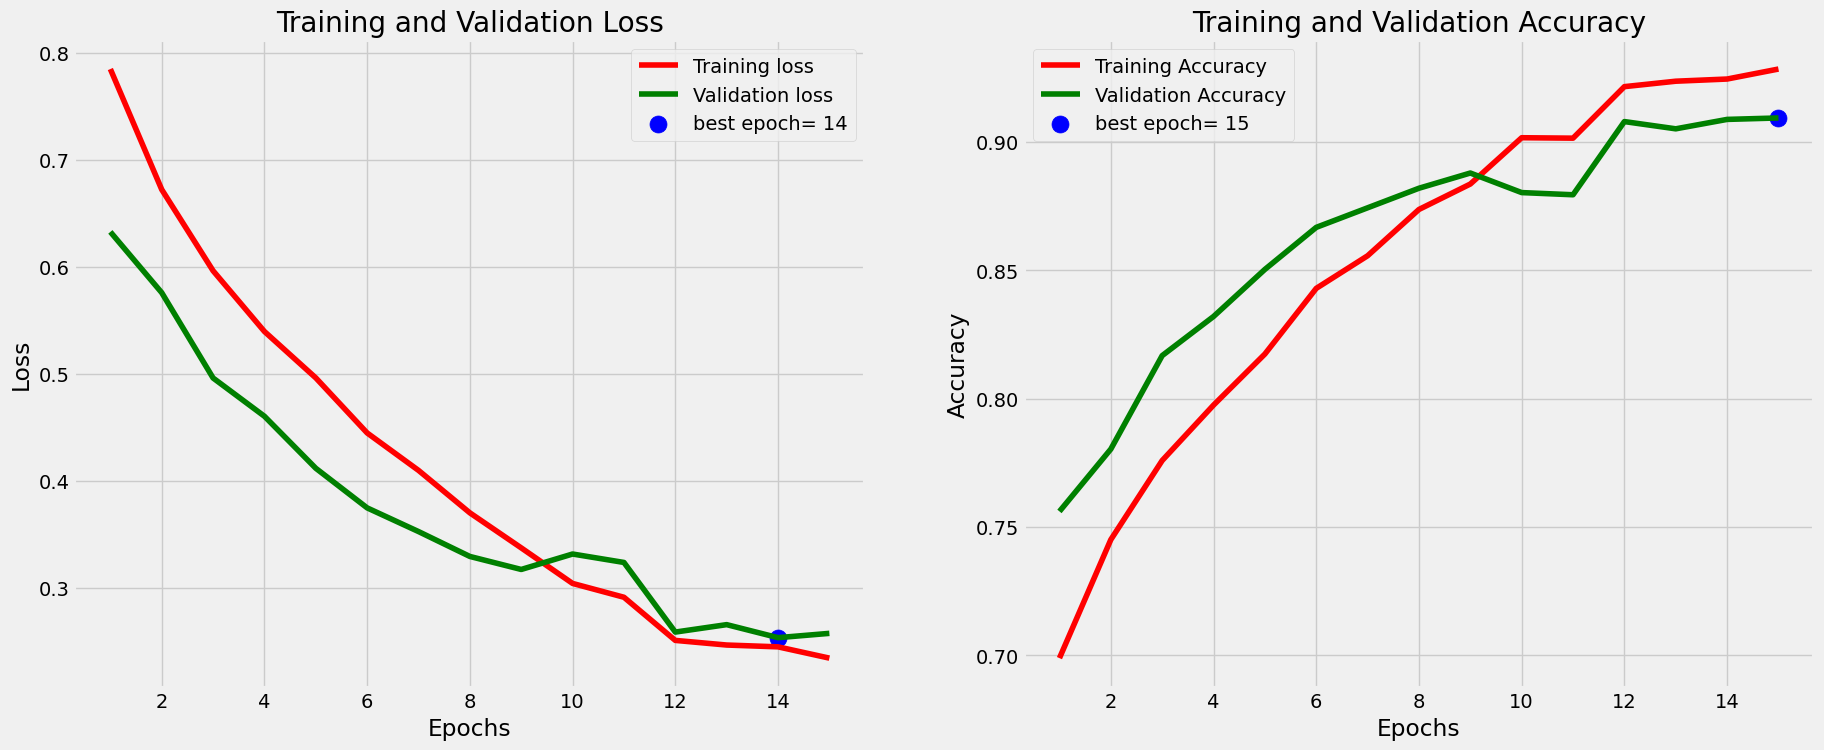

In [58]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# model.evaluate

In [59]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.26113
Test Accuracy: 90.78%


# F1 Score / Recall / Precision

In [60]:
y_true = test_images.classes
y_pred = np.argmax(model.predict(test_images), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_images.class_indices.keys()))

F1 Score: 0.9285877753087789
                       precision    recall  f1-score   support

            Big Truck       1.00      0.98      0.99        42
             City Car       0.93      0.87      0.90       442
Multi Purpose Vehicle       0.80      0.85      0.83       222
                Sedan       0.86      0.97      0.91       235
Sport Utility Vehicle       0.95      0.83      0.88       162
                Truck       0.98      1.00      0.99       100
                  Van       0.95      0.98      0.96       179
                  cat       0.90      0.90      0.90        10
          caterpillar       1.00      1.00      1.00         6
            cockroach       1.00      1.00      1.00         5
                  cow       1.00      0.78      0.88         9
                  dog       0.67      0.86      0.75         7
                  rat       1.00      1.00      1.00         9
        refrigerators       1.00      0.95      0.97        19
                sofas    

# Get Predictions

In [61]:
classes = dict(zip(test_images.class_indices.values(), test_images.class_indices.keys()))
Predictions = pd.DataFrame({"Image Index" : list(range(len(test_images.labels))), 
                            "Test Labels" : test_images.labels, 
                            "Test Classes" : [classes[i] for i in test_images.labels],
                            "Prediction Labels" : y_pred,
                            "Prediction Classes" : [classes[i] for i in y_pred],
                            "Path": test_images.filenames,
                            "Prediction Probability" : [x for x in np.asarray(tf.reduce_max(model.predict(test_images), axis = 1))]
                           })
Predictions.head(8)

,Image Index,Test Labels,Test Classes,Prediction Labels,Prediction Classes,Path,Prediction Probability
0,0,1,City Car,1,City Car,/kaggle/input/vehicle-images-dataset/City Car/...,0.647756
1,1,3,Sedan,3,Sedan,/kaggle/input/vehicle-images-dataset/Sedan/Ima...,0.983118
2,2,13,refrigerators,13,refrigerators,/kaggle/input/dollar-street-dataset/Dollar str...,0.999931
3,3,2,Multi Purpose Vehicle,2,Multi Purpose Vehicle,/kaggle/input/vehicle-images-dataset/Multi Pur...,0.650162
4,4,3,Sedan,1,City Car,/kaggle/input/vehicle-images-dataset/Sedan/Ima...,0.559807
5,5,2,Multi Purpose Vehicle,2,Multi Purpose Vehicle,/kaggle/input/vehicle-images-dataset/Multi Pur...,0.897003
6,6,3,Sedan,3,Sedan,/kaggle/input/vehicle-images-dataset/Sedan/Ima...,0.825003
7,7,6,Van,6,Van,/kaggle/input/vehicle-images-dataset/Van/Image...,0.995202


# Print the most confident errors

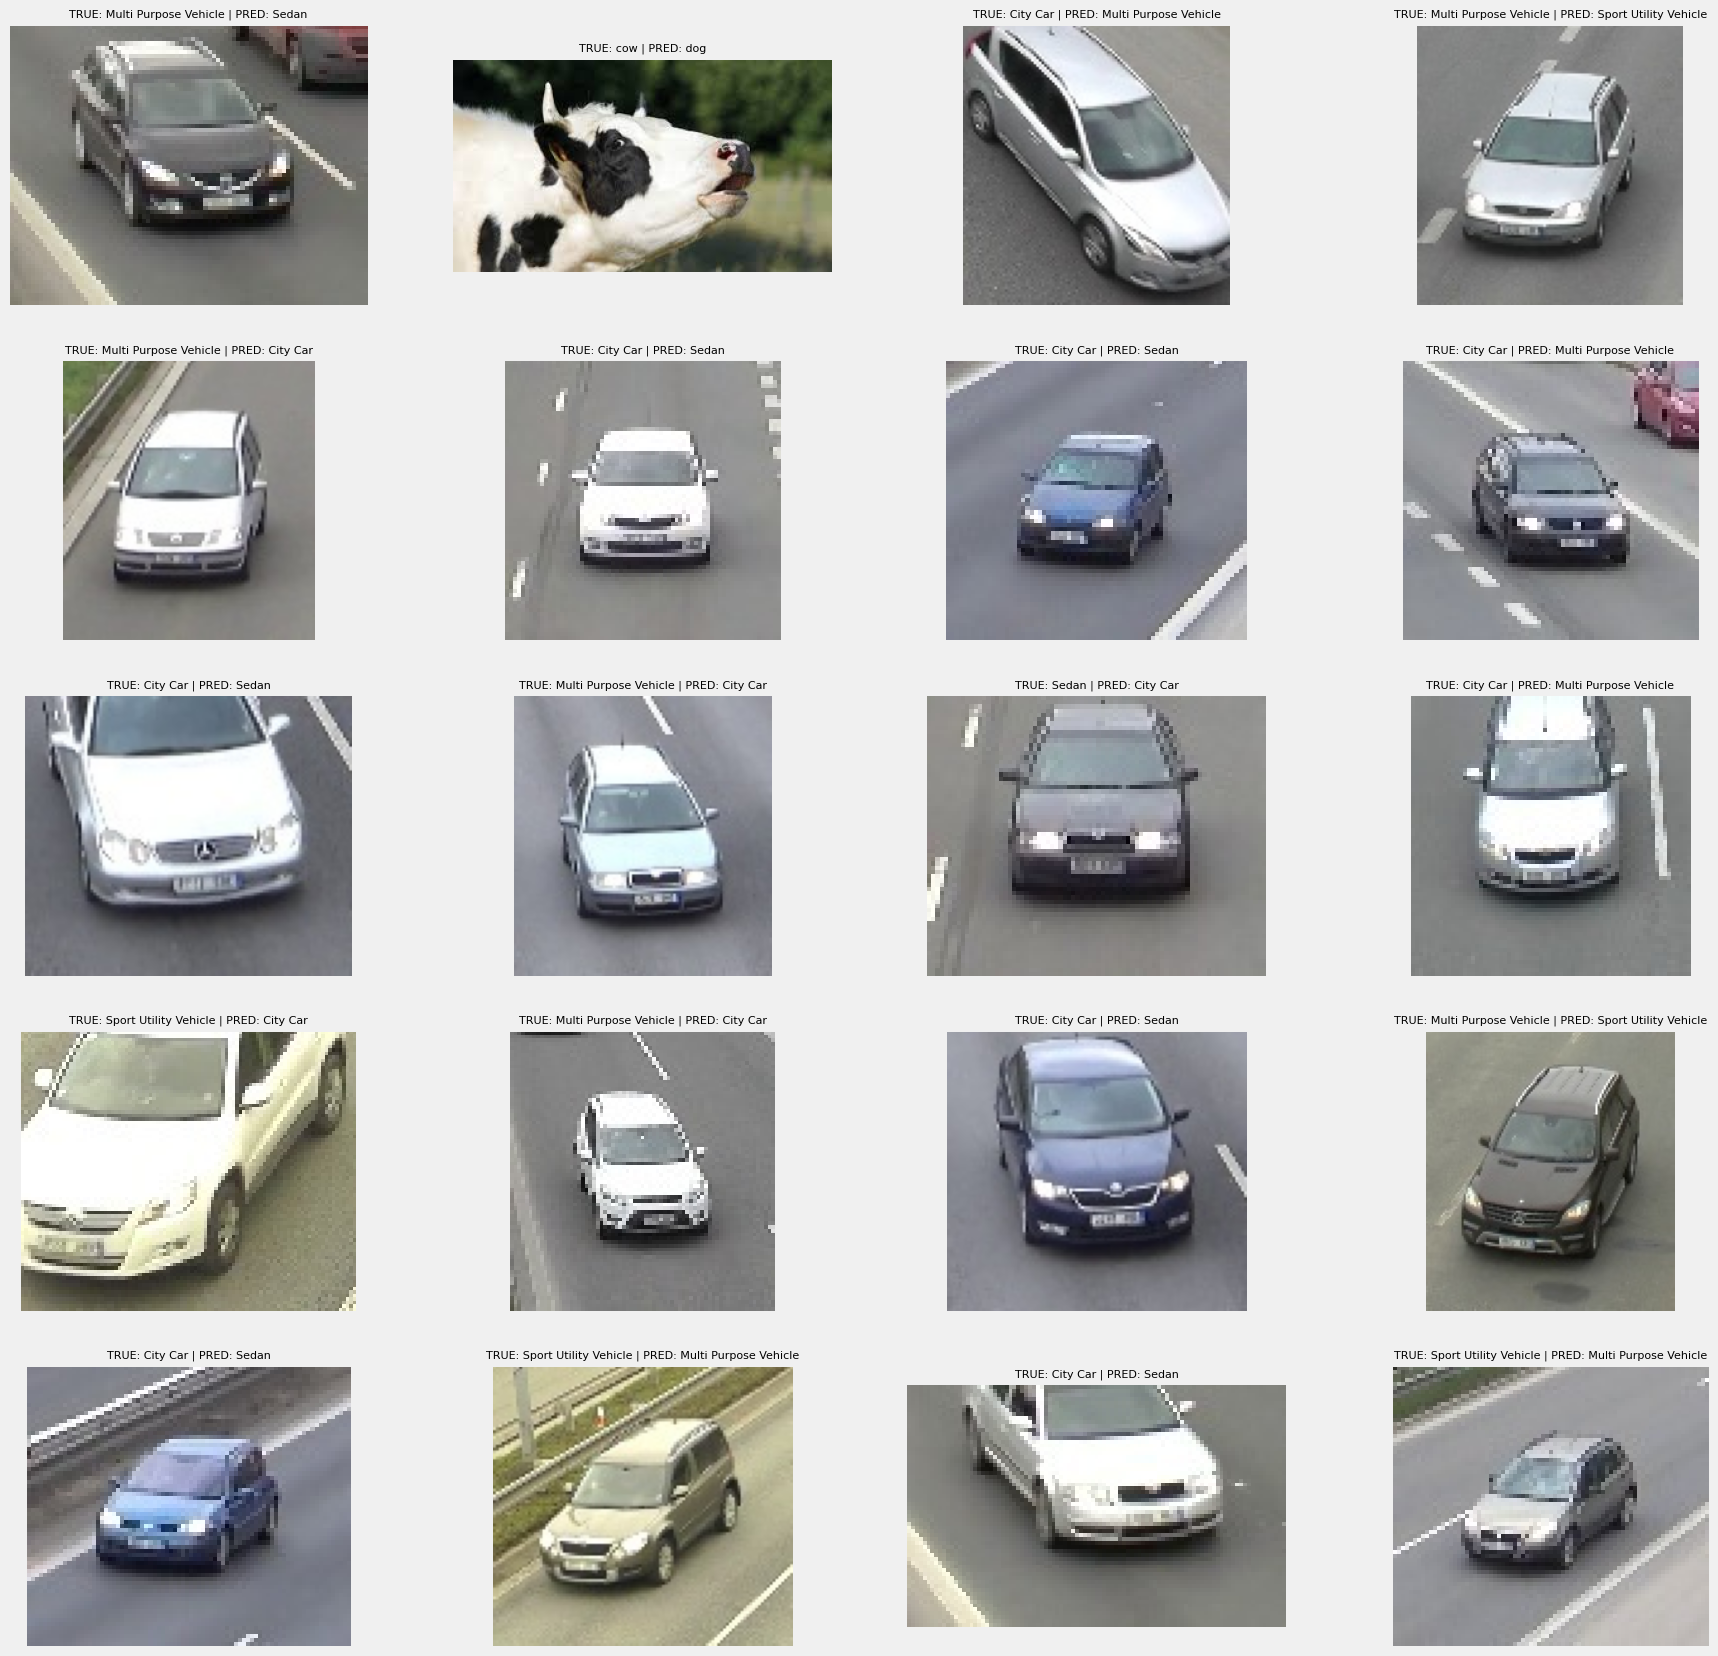

In [62]:
plt.figure(figsize=(20,20))
for i, row in Predictions[Predictions["Test Labels"] != Predictions["Prediction Labels"]].sort_values("Prediction Probability").tail(20).reset_index().iterrows():
    plt.subplot(5,4,i+1)
    image_path = row['Path']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'TRUE: {row["Test Classes"]} | PRED: {row["Prediction Classes"]}', fontsize=8)
    plt.axis('off')
    
plt.show()

# Confusion Matrics and Classification Report

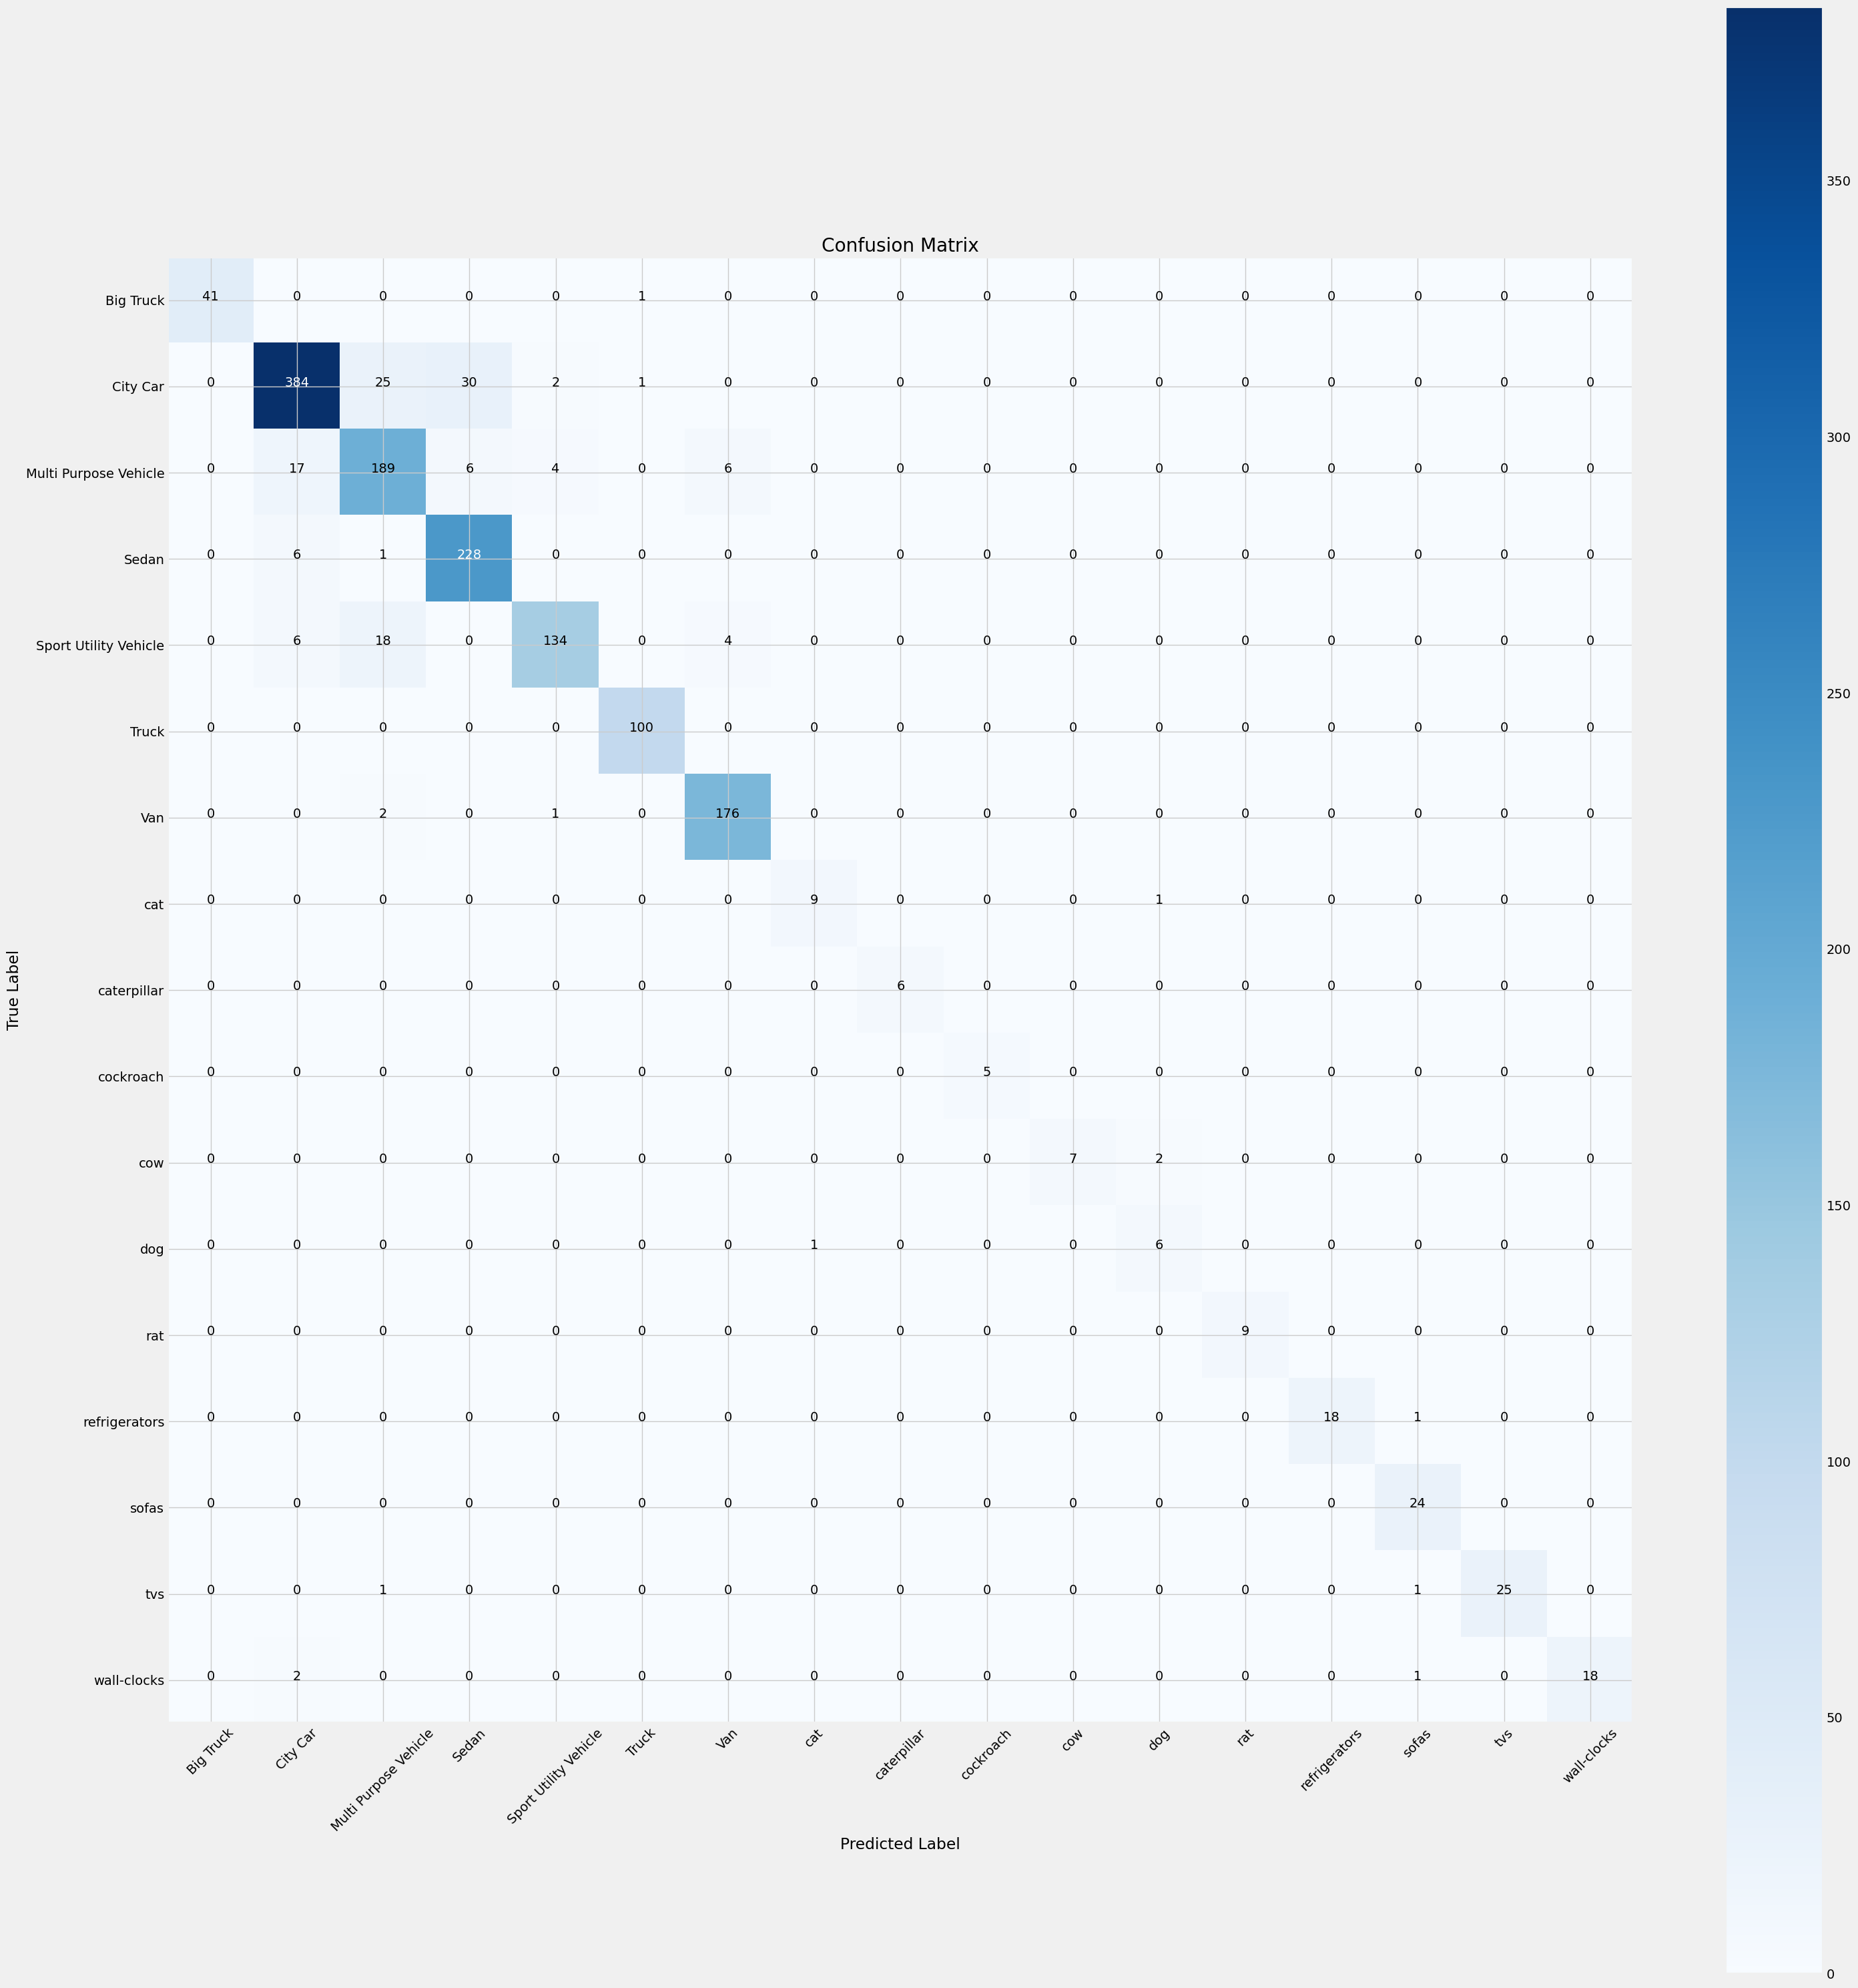

In [63]:
preds = model.predict_generator(test_images)
y_pred = np.argmax(preds, axis=1)
g_dict = test_images.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_images.classes, y_pred)

plt.figure(figsize= (30, 30))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [64]:
# Save the entire model to a HDF5 file
model.save('dailyobjects.h5')


